In [1]:
from pathlib import Path
from typing import List
from itertools import chain
from collections import Counter, defaultdict
import copy
import os
import json

import numpy as np
import scipy
import pandas as pd
from tqdm.auto import tqdm

# Text & NLP
import spacy
from spacy.matcher import Matcher
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, Word2Vec
from gensim.models.phrases import Phrases
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from empath import Empath

# Transformers
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset
import torch

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models
from wordcloud import WordCloud
from wordcloud import STOPWORDS as wordcloud_stopwords
import plotly.express as px


sns.set_theme()

C:\anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [3]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  # Not an elegant fix for Intel OPENMP problem on Windows. 

## Load data

In [4]:
data_path = Path('../data/')

The main dataset for NLP analysis is tokenized subtitle dataframe. In `NLP-Tokenization.ipynb` each subtitle document is tokenized and words are reduced to their lemmas.

In [5]:
subtitles_tokinezed = pd.read_parquet(data_path.joinpath('processed/subtitles_tokenized.parquet.gzip'))
subtitles_tokinezed.head()

,Wikidata ID,Text,Freebase ID,IMDb ID
0,Q1755660,"[Divine, Comedy, Dante, Alighieri, HELL, art, ...",/m/07jcl5,tt0002130
1,Q2576383,"[MABEL, WHEEL, Parte, Farce, Comedy, lover, wo...",/m/02rd2pn,tt0004277
2,Q2294948,"[fireman, let, house, insuranceand, daughter, ...",/m/09lh9c,tt0006684
3,Q1923676,"[cure, health, spring, throw, liquor, dinner, ...",/m/09t69n,tt0007832
4,Q1070484,"[dog, life, Dawn, scrap, thoroughbred, mongrel...",/m/07mlsy,tt0009018


(27329, 5)

We also analyze plot summaries that are also tokenized along with subtitles.

In [6]:
summaries_tokinezed = pd.read_parquet(data_path.joinpath('processed/summaries_tokinezed.parquet.gzip'))
summaries_tokinezed.head()

,Freebase ID,Text,Wikidata ID,IMDb ID
0,/m/076w2lb,"[Shlykov, hard, work, taxi, driver, Lyosha, sa...",Q2552456,tt0100757
1,/m/0gkz15s,"[nation, Panem, consist, wealthy, Capitol, poo...",Q212965,tt1392170
2,/m/051zjwb,"[Poovalli, Induchoodan, sentence, year, prison...",Q6965425,tt0273870
3,/m/06xtz3,"[Lemon, Drop, Kid, New, York, City, swindler, ...",Q7746905,tt0043733
4,/m/02tqm5,"[seventh, day, Adventist, Church, pastor, Mich...",Q1249239,tt0094924


`chars_extended.csv` contains combined information from CMU movie corpus dataset and Wikidata dataset that we collected. In this part we mainly use it to get release dates of movies.

In [7]:
metadata = pd.read_csv(data_path.joinpath('processed/chars_extended.csv'))
metadata.head()

,movie_freebase_id,movie_id,movie_name,movie_genre,movie_origin,movie_release,box_office_value,director_id,director_name,director_gender,...,cast_3_country,cast_3_birth,cast_3_age_at_release,cast_id_4,cast_4_name,cast_4_gender,cast_4_country,cast_4_birth,cast_4_age_at_release,movie_imdb_id
0,/m/02rjv0t,Q1000394,This Modern Age,drama film,United States of America,1931-08-29,NaN,Q1985392,Nick Grinde,male,...,France,1878-06-02,53.0,Q2831060,Albert Conti,male,United States of America,1887-01-29,44.0,tt0022478
1,/m/0gjdn2_,Q1000174,Tinko,NaN,NaN,1957-01-01,NaN,Q1379822,Herbert Ballmann,male,...,Germany,1898-02-21,59.0,Q1442953,Hans Hardt-Hardtloff,male,Germany,1906-08-08,51.0,tt0131068
2,/m/0g5xtz,Q1000825,Jan Dara,LGBT-related film,Thailand,2001-01-01,NaN,Q360509,Nonzee Nimibutr,male,...,Thailand,1940-01-24,61.0,Q16305292,NaN,male,NaN,1975-03-26,26.0,tt0282628
3,/m/0czdkjd,Q1001102,The Rat Savior,horror film,Socialist Federal Republic of Yugoslavia,1976-10-26,NaN,Q3199956,Krsto Papić,male,...,Croatia,1932-01-04,44.0,Q12628320,Branko Špoljar,male,NaN,1914-01-05,62.0,tt0074701
4,/m/0f1r9p,Q1000826,Guns of the Magnificent Seven,Western film,United States of America,1969-01-01,NaN,Q450601,Paul Wendkos,male,...,United States of America,1914-07-24,55.0,Q465643,George Rigaud,male,Argentina,1905-08-11,64.0,tt0064395


#### Get movie release dates from metada table

To text features across different years, we add the relase year for each subtitle.

In [8]:
movie_release = metadata.set_index('movie_id').loc[subtitles_tokinezed['Wikidata ID'],'movie_release']
subtitles_tokinezed['year'] = movie_release.copy().values

# Take entries with movie release dates
subtitles_with_dates = subtitles_tokinezed[subtitles_tokinezed['year'].notna()].copy()

# Only keep years and sort wrt years
subtitles_with_dates['year'] = subtitles_with_dates['year'].apply(lambda x: int(x.split('-')[0]))
subtitles_with_dates.sort_values('year', inplace=True)
subtitles_with_dates.head()

,Wikidata ID,Text,Freebase ID,IMDb ID,year
22571,Q2913387,"[doc, pill, sure, work, sure, don, hear, compl...",/m/0gj9h_4,tt1202028,1890
12937,Q1210171,"[Flamingo, Road, town, street, social, success...",/m/02_1qn,tt0241373,1891
13390,Q6555342,"[moral, tale, bakery, girl, MONCEAU, Paris, Vi...",/m/0gx1hz2,tt0256884,1896
25590,Q1141772,"[dad, socialist, kulak, dad, come, dad, come, ...",/m/02vmcc2,tt1728115,1896
26841,Q8049397,"[fund, knowledge, discipline, ideal, hold, pre...",/m/0gx1419,tt2262465,1896


We also add year information to summary dataframe.

In [9]:
# Not that our `metadata` table has been augmented with Wikidata and contains more complete release date information than CMU dataset
mask = summaries_tokinezed['Freebase ID'].isin(metadata['movie_freebase_id'])
movie_release = metadata.set_index('movie_id').loc[summaries_tokinezed.loc[mask, 'Wikidata ID'],'movie_release']
summaries_tokinezed.loc[mask, 'year'] = movie_release.copy().values

# Take entries with movie release dates
summaries_with_dates = summaries_tokinezed[summaries_tokinezed['year'].notna()].copy()

# Only keep years and sort wrt years
summaries_with_dates['year'] = summaries_with_dates['year'].apply(lambda x: int(x.split('-')[0]))
summaries_with_dates.sort_values('year', inplace=True)
summaries_with_dates.head()

,Freebase ID,Text,Wikidata ID,IMDb ID,year
20052,/m/07mgtk,"[queen, wish, naughty, daughter, turn, raven, ...",Q875764,None,1815
20713,/m/0jq3g,"[scene, film, stationary, camera, screen, larg...",Q470705,tt0000005,1893
23174,/m/02q8pr6,"[film, consist, series, animation, beach, cont...",Q2535572,tt0000015,1894
32127,/m/02q1zd3,"[James, Corbett, Peter, Courtney, specially, a...",Q2563406,tt0000007,1894
20679,/m/02q23xk,"[find, father, suffer, financial, problem, Jer...",Q6876874,tt0000009,1894


These are main keyword that our analyses revolves aroud.

In [10]:
KEYWORDS = [
    'man', 
    'woman', 
    'gay', 
    'lesbian', 
    'transexual', 
    'bisexual', 
    'queer', 
    'american', 
    'russian', 
    'chinese', 
    'indian', 
    'mexican',
    'african'
]

KEYWORDS_DIVERSITY = [
    'man', 
    'woman', 
    'gay', 
    'lesbian', 
#     'transexual', 
    'bisexual', 
    'queer'
]

KEYWORDS_ETHNICITY = [
    'american', 
    'russian', 
    'chinese', 
    'indian', 
    'mexican',
    'african'
]

### Inspecting subtitle dataset

#### Splitting subtitles across years

As it is shown in the figure below, the number available subtitles in our dataset across years are not uniformly distributed. As we don not have enough data for movies before 1970, comparison across year would not yield statistically significant results. To remedy this, we split subtitles into 5 different groups such that each of which has the same number of tokens.

Text(0.5, 1.0, 'Number of available subtitles per year')

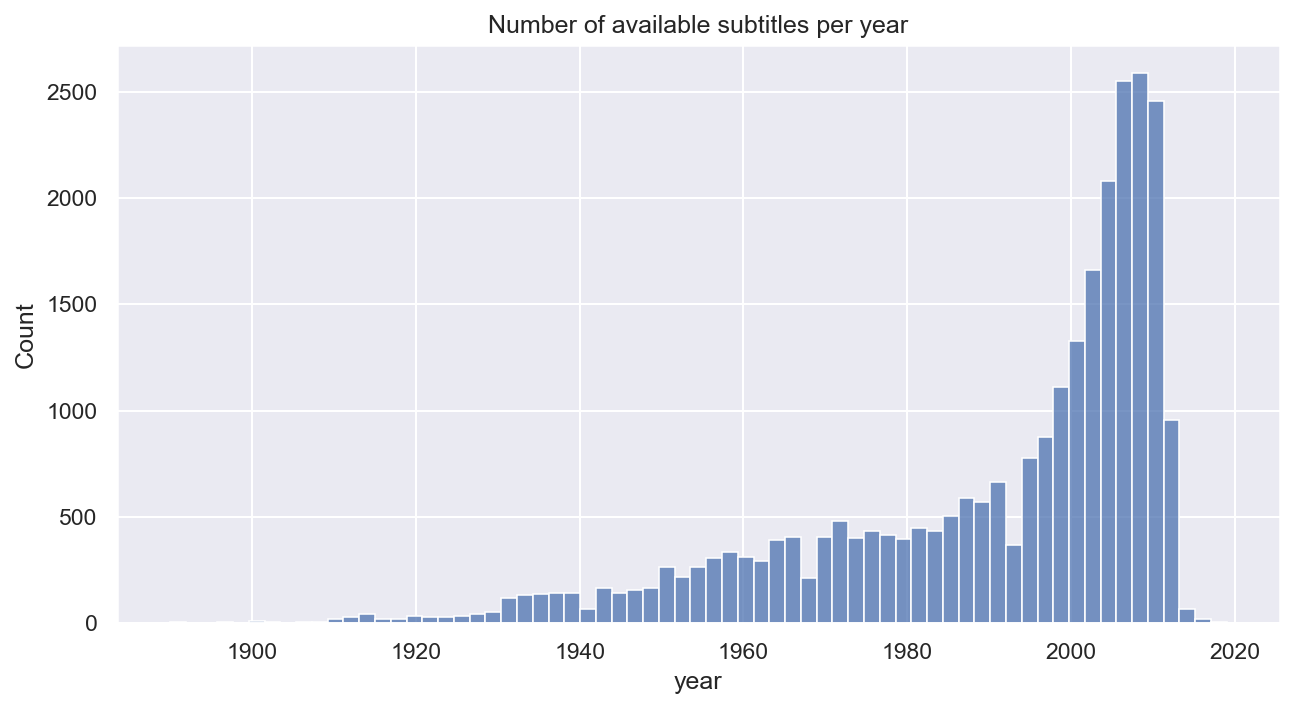

In [16]:
fig, ax = plt.subplots(dpi=150, figsize=(10, 5))
sns.histplot(subtitles_with_dates, x='year', ax=ax)
ax.set_title('Number of available subtitles per year')

In [274]:
N_INTERVALS = 5

subtitles_with_dates['length'] = subtitles_with_dates['Text'].apply(len)
total_length = subtitles_with_dates['length'].sum()
bin_edges = np.linspace(start=0, stop=1, num=N_INTERVALS+1)*total_length
subtitles_with_dates['length_cumulative'] = subtitles_with_dates['length'].cumsum()

In [275]:
def assign_bin(cumulative_sum, bin_edges):
    thresholds = cumulative_sum <= bin_edges
    bin_id = np.where(thresholds)[0][0] #  Bin id is the minimum threshold level the cumulative value exceeds
    return bin_id

subtitles_with_dates['interval_id'] = subtitles_with_dates['length_cumulative'].apply(assign_bin, bin_edges=bin_edges)

In [276]:
# Control
subtitles_with_dates.groupby('interval_id').apply(lambda x:x['length'].sum())

interval_id
1    14902928
2    14901465
3    14905044
4    14905655
5    14903902
dtype: int64

In [67]:
intervals = {}

for idx, group in subtitles_with_dates.groupby('interval_id'):
    year_min, year_max = group['year'].min(), group['year'].max()
    
    intervals[idx] = f'{year_min}-{year_max}'
    print(f'Interval {idx}: {intervals[idx]}')

Interval 1: 1890-1972
Interval 2: 1972-1994
Interval 3: 1994-2003
Interval 4: 2003-2008
Interval 5: 2008-2019


#### Genre distribution

The distribution of subtitles in the dataset over the genres are shown for top 20 genres below. The distribution follows closely the distribution of the CMU movie corpus dataset and follows power law.

In [54]:
df = subtitles_with_dates.copy()
df['genre'] = metadata.set_index('movie_id').loc[df['Wikidata ID'], 'movie_genre'].values
genre = df['genre'].value_counts()[:20]
df = df[df['genre'].isin(genre.index)]

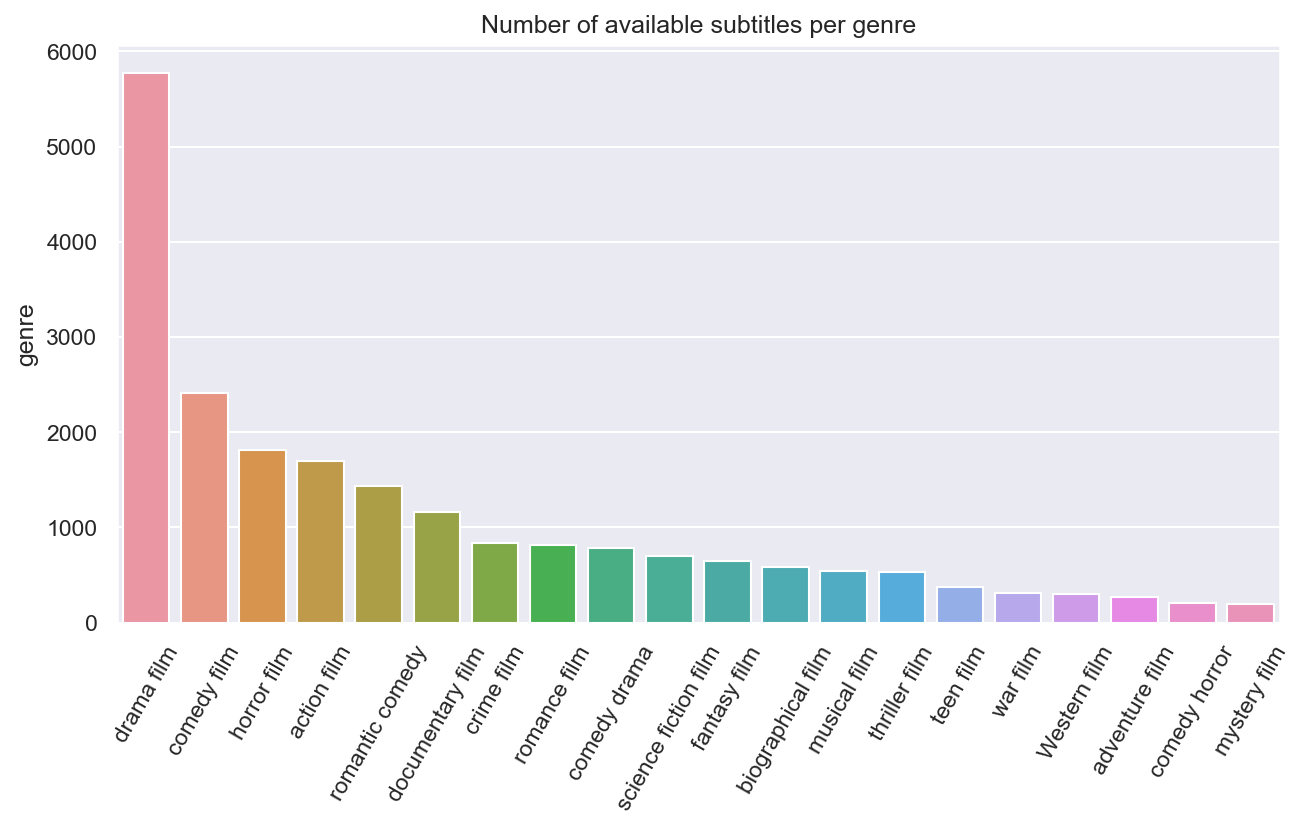

In [70]:
fig, ax = plt.subplots(dpi=150, figsize=(10, 5))
sns.barplot(x=genre.index, y=genre)
ax.set_title('Number of available subtitles per genre')
ax.set_xticklabels(genre.index, rotation = 60)
pass

## Sentiment Analysis

In this section, we aim to classify sentiment scores of our keyword list across years. 

### Analysis
We perform the analysis using two different models on two different data modalities. The first model is [VADER](https://github.com/cjhutto/vaderSentiment) (Valence Aware Dictionary for Sentiment Reasoning) which is a lexicon and rule-based sentiment analysis tool. The second model is a transformer based sentiment analyzer, [roBERTa-base](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest), that is trained on ~124M tweets  from January 2018 to December 2021. Although we don't classify tweets, a conversation in a subtitle usually reflects the characteristics of daily language used in public. In addition, an advantage of a transformer-based model over lexicon & rule-based method is that transformers can also capture the contextual information thank to the self-attention mechanism where each token interacts with each others. Hence we hypothesized that this model should be good enough capture sentiment scores of conversations in subtitles.

In terms of data modalities, we both used raw text inputs (not tokenized&lemmatized) and tokenized context windows to the models. In the context window approach, we start with tokenized subtitle documents and search for occurrences of a keyword. For each occurrence, we extract a context window around the keyword. In the other approach, we first identify a keyword occurs in the list of tokens of a document. If it does, we read the raw subtitle file and return the sentences containing the keyword. However, this approach is not precises as we look at the whole text, rather than tokens, hence a sentence containing `woman` can be return for the keyword `man`, since `man` is 'suffix' of `woman`. To remove false positives, we feed sentences through an NLP tokenization pipeline and check whether a keyword is actually a token of the sentence.

#### Helper Functions for Sentiment Analysis

In [ ]:
def build_term_contexts(row, keyword:str, window_size:int = 10)-> List[dict]:
    '''
    For a given keyword, searches through all the tokenized text and records each occureneces of a token
    and its surround context window with a defined size.  
    '''
    
    doc_array = np.array(row['Text'])
    doc_len = len(doc_array)
    occurences = np.where(keyword == doc_array)[0] # Find occurences of the keyword
    contexts = []
    
    # For each occurence, capture its context windows and save them with their related metada
    for occ in occurences:
        min_index, max_index = max(0, occ-window_size), min(doc_len, occ+window_size)
        context = doc_array[min_index:max_index] # Extract a context window
        
        # Add the current context to the list with the corresponding metada
        contexts.append({
            'Wikidata ID': row['Wikidata ID'],
            'IMDb ID': row['IMDb ID'],
            'Freebase ID': row['Freebase ID'],
            'year':row['year'],
            'Context': context})
    
    return contexts


def extract_sentences(row, keyword:str, path:Path = data_path.joinpath('raw/subtitles'))-> List[dict]:
    '''
    For a given keyword, load preprocessed but not tokenized subtitles and extract sentences in which the keyword appears. 
    '''
    
    doc_array = np.array(row['Text'])
    doc_len = len(doc_array)
    
    # First check if the keyword is part of the tokenized text to filter out unnecessary loading of text.
    occurences = np.where(keyword == doc_array)[0] 
    if len(occurences) == 0: 
        return []
    
    # Load the subtitle file
    with open(path.joinpath(row['IMDb ID'] + '.txt'), 'r', encoding='utf-8') as file:
        text = file.readlines()
        
    # In the preprocessed subtitle file, each line is a sentence.
    # Keep a sentence if it includes the keyword.
    text = [sent.replace('\n', ' ') for sent in text]
    text = [sent for sent in text if keyword in sent]
    
    # Save the found sentences with metada
    sentences = [{
            'Wikidata ID': row['Wikidata ID'],
            'IMDb ID': row['IMDb ID'],
            'Freebase ID': row['Freebase ID'],
            'year':row['year'],
            'Text': sent} 
        for sent in text]
    
    return sentences


def vader_score(text, analyzer, score_type='compound') -> float:
    '''
    Analyze a text with Vader sentiment analyzer and return the compound score.
    '''
    sentiment_scores = analyzer(text)
    return sentiment_scores[score_type]

def expand_transformer_score(row, output:dict) -> dict:
    '''
    Map different output conventions of sentiment analysis transformer models to 
    a predefined dictionary structure. Useful to try out different models.
    '''
    
    sentiment = {}
    for sent in output:
        label = sent['label']
        score = sent['score']
        
        if label in ['NEGATIVE', 'negative', 'LABEL_0']:
            sentiment['Negative'] = score
        elif label in ['POSITIVE', 'positive', 'LABEL_2']:
            sentiment['Positive'] = score
        else:
            sentiment['Neutral'] = score
                
    label = sorted(sentiment, key=sentiment.get)[-1]
    
    for feat in ['Negative', 'Neutral', 'Positive']:
        row[feat] = sentiment[feat]
        
    label_map = {'Negative':-1, 'Neutral':0, 'Positive':+1}
    row['Label'] = label_map[label]
    
    
    return row

def transfomer_score(row, pipeline, batch:bool=True):
    '''
    Analyze a text with a transformer-based sentiment analyzer on CPU and return scores and the label.
    '''
    text = row['Text']
    output = pipeline(text)
    
    if batch==True:
        output = output[0] # Batch size is 1 on CPU
        
    return expand_transformer_score(row, output)


def process_text(documents:dict, nlp_pipeline, n_process:int=1, batch_size:int=100):
    '''
    Using Spacy's NLP pipeline, lemmatize and tokenize text documents.
    Adapted from ADA 2022 textual data analysis exercise.
    '''

    # Assign document ids, values
    doc_ids, doc_vals = documents.keys(), documents.values()
    n_docs = len(documents)
    
    processed_docs = list()
    for doc_id, doc in tqdm(zip(doc_ids, nlp.pipe(doc_vals, n_process=n_process, batch_size=batch_size)), total=n_docs, leave=False):

        # Process document using Spacy NLP pipeline.
        ents = doc.ents  # Named entities

        # Keep only words (no numbers, no punctuation).
        # Lemmatize tokens, remove punctuation and remove stopwords.
        doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

        # Remove common words from a stopword list and keep only words of length 3 or more.
        doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

        # Add named entities, but only if they are a compound of more than word.
        doc.extend([str(entity) for entity in ents if len(entity) > 1])

        
        processed_docs.append({'ID':doc_id, 'Text':doc})
        
    return processed_docs

def check_token(df:pd.DataFrame, token:str, nlp_pipeline, feat_name:str='Text'):
    '''
    Filter out entries that a given token does not occur.
    '''
    
    tokenized_texts = process_text(df[feat_name].to_dict(), nlp_pipeline=nlp)
    tokenized_texts = pd.DataFrame(tokenized_texts)
    
    tokenized_texts['label'] = tokenized_texts['Text'].apply(lambda text: True if token in text else False)
    index = tokenized_texts .loc[tokenized_texts['label'], 'ID']

    return df.loc[index].copy()

#### Models

In [ ]:
# Lexicon-based sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

# Transformer-based sentiment analyzer
model ='cardiffnlp/twitter-roberta-base-sentiment-latest'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sentiment_pipeline = pipeline(task='sentiment-analysis', model=model, device=device, top_k=None)

# Tokenization model for cross-checking
spacy.require_cpu()
nlp = spacy.load('en_core_web_lg')
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

#### Analyze

In [ ]:
for keyword in tqdm(KEYWORDS):
    # For a given keyword, extract its context windows for all its occurences
    contexts = subtitles_with_dates.apply(build_term_contexts, keyword=keyword, axis=1).copy()
    contexts = list(chain(*contexts)) # Concatenate lists
    df_contexts = pd.DataFrame(contexts)
    df_contexts['Text'] = df_contexts['Context'].apply(lambda x: ' '.join(x))
    
    # For a given keyword, read all raw sentences from subtitles including the keyword
    sentences = subtitles_with_dates.apply(extract_sentences, keyword=keyword, axis=1)
    sentences = list(chain(*sentences)) # Concatenate lists
    df_sentences = pd.DataFrame(sentences)
    df_sentences = check_token(df_sentences, token=keyword, nlp_pipeline=nlp, feat_name='Text') # Remove false positives
    
    # Apply Vader sentiment analysis
    df_contexts['vader_score'] = df_contexts['Text'].apply(vader_score, analyzer=vader_analyzer.polarity_scores)
    df_sentences['vader_score'] = df_sentences['Text'].apply(vader_score, analyzer=vader_analyzer.polarity_scores)
    

    # Transformer based sentiment analysis on context windows
    ds = KeyDataset(Dataset.from_pandas(df_contexts), 'Text')
    scores = []
    for idx, output in tqdm(zip(df_contexts.index, sentiment_pipeline(ds, batch_size=256)), total=len(df_contexts), leave=False):
        scores.append(expand_transformer_score(df_contexts.loc[idx].copy(), output=output))
    df_contexts = pd.DataFrame(scores)
    
    # Transformer based sentiment analysis on sentences
    ds = KeyDataset(Dataset.from_pandas(df_sentences), 'Text')
    scores = []
    for idx, output in tqdm(zip(df_sentences.index, sentiment_pipeline(ds, batch_size=256)), total=len(df_sentences), leave=False):
        scores.append(expand_transformer_score(df_sentences.loc[idx].copy(), output=output))
    df_sentences = pd.DataFrame(scores)
    
    # Save results for plotting
    df_contexts.to_parquet(data_path.joinpath(f'processed/sentiment_analysis/{keyword}_contexts.parquet.gzip'))
    df_sentences.to_parquet(data_path.joinpath(f'processed/sentiment_analysis/{keyword}_sentences.parquet.gzip'))

### Results

In this section we visualize and interpret the results of sentiment analysis. We first load the stored dataframes and set their corresponding year interval based on the previous assignment.

In [76]:
contexts = {}
for keyword in KEYWORDS:
    contexts[keyword] = pd.read_parquet(data_path.joinpath(f'processed/sentiment_analysis/{keyword}_contexts.parquet.gzip'))
    
sentences = {}
for keyword in KEYWORDS:
    sentences[keyword] = pd.read_parquet(data_path.joinpath(f'processed/sentiment_analysis/{keyword}_sentences.parquet.gzip'))

In [77]:
for keyword in tqdm(KEYWORDS):
    df_sentences = sentences[keyword]
    interval_ids = subtitles_with_dates.set_index('Wikidata ID').loc[df_sentences['Wikidata ID'], 'interval_id']
    df_sentences['interval_id'] = interval_ids.values
    
    df_contexts = contexts[keyword]
    interval_ids = subtitles_with_dates.set_index('Wikidata ID').loc[df_contexts['Wikidata ID'], 'interval_id']
    df_contexts['interval_id'] = interval_ids.values

  0%|          | 0/13 [00:00<?, ?it/s]

#### Distribution of sentiments

To interpret the results later on more accurately, we calculate the fraction of each sentiment (positive, neutral, negative).

In [293]:
sentiment_stats = []

for keyword in tqdm(KEYWORDS):
    for idx, group in sentences[keyword].groupby('interval_id'):
        n_pos = (group['Label']==+1).sum()
        n_neu = (group['Label']==0).sum()
        n_neg = (group['Label']==-1).sum()
        
        total = n_pos + n_neu + n_neg
        if total==0:
            n_pos = 0
            n_neu = 0
            n_neg = 0
        else:
            n_pos /= total
            n_neu /= total
            n_neg /= total
        
        sentiment_stats.append({
            'keyword':keyword,
            'interval_id':idx,
            'sentiment':'Positive',
            'sent_frac':n_pos
        })
        
        sentiment_stats.append({
            'keyword':keyword,
            'interval_id':idx,
            'sentiment':'Neutral',
            'sent_frac':n_neu
        })
        
        sentiment_stats.append({
            'keyword':keyword,
            'interval_id':idx,
            'sentiment':'Negative',
            'sent_frac':n_neg
        })
        
df_sent_stats = pd.DataFrame(sentiment_stats)

  0%|          | 0/13 [00:00<?, ?it/s]

Text(0, 0.5, 'Fraction')

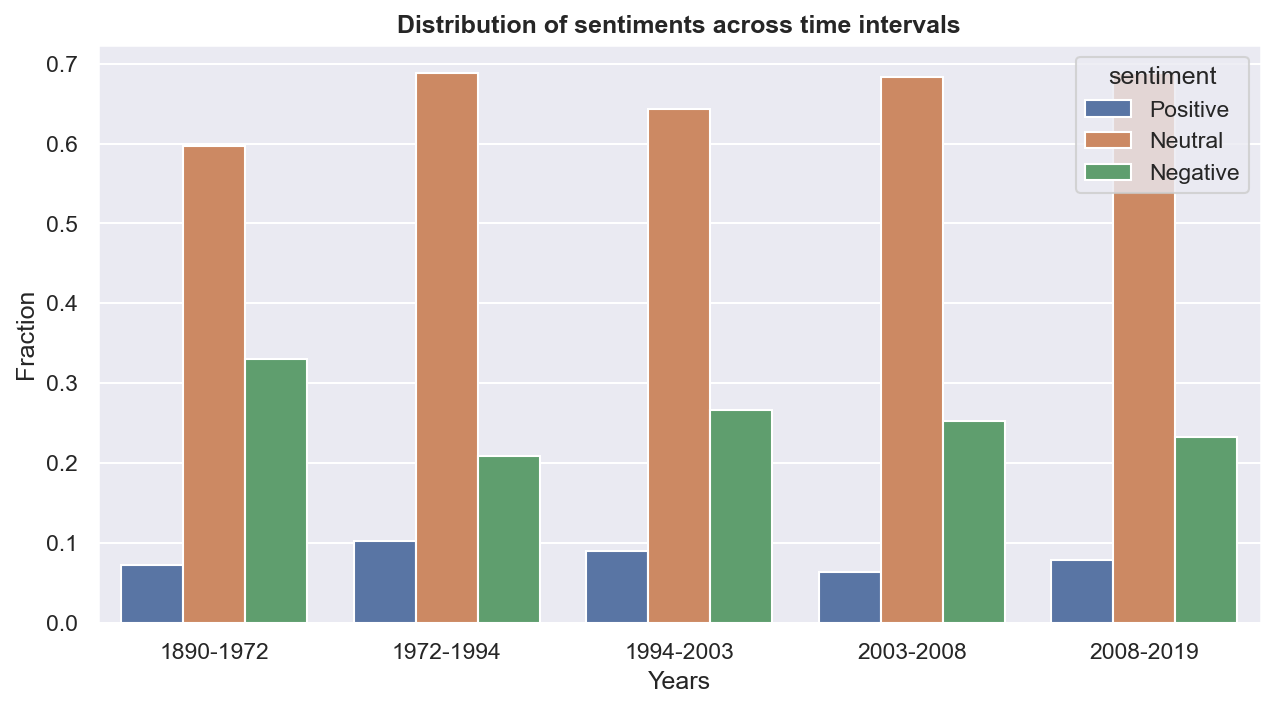

In [237]:
fig, ax = plt.subplots(dpi=150, figsize=(10, 5))
sns.barplot(df_sent_stats, x='interval_id', y='sent_frac', hue='sentiment', errorbar=None)

ax.set_title('Distribution of sentiments across time intervals', fontweight='bold')
ax.set_xlabel('Years')
ax.set_xticklabels(list(intervals.values()))
ax.set_ylabel('Fraction')

In the plot above, we observe that the dominant sentiment across different years is `neutral`, followed by `negative`.

In [257]:
# fig = px.bar(
#     df_sent_stats, 
#     x='keyword', 
#     y='sent_frac', 
#     color='sentiment',
#     facet_row='interval_id', 
#     color_discrete_sequence=px.colors.qualitative.T10,
#     template='ggplot2'
#        )


# fig.update_layout(
#     yaxis = dict(
#             tickmode = 'array',
#             tickvals = list(intervals.keys()),
#             ticktext = list(intervals.values())
#         ),

#     title={
#         'text': '<b>Sentiment Analysis - Ethinicty<b>',
#         'y':0.95,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top',
#         'font':{
#             'size':20,
#         }
#     },
    
# )

# fig.show()

C:\anaconda3\lib\site-packages\seaborn\axisgrid.py:712: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



Text(1216.8333333333335, 0.5, 'Fraction')

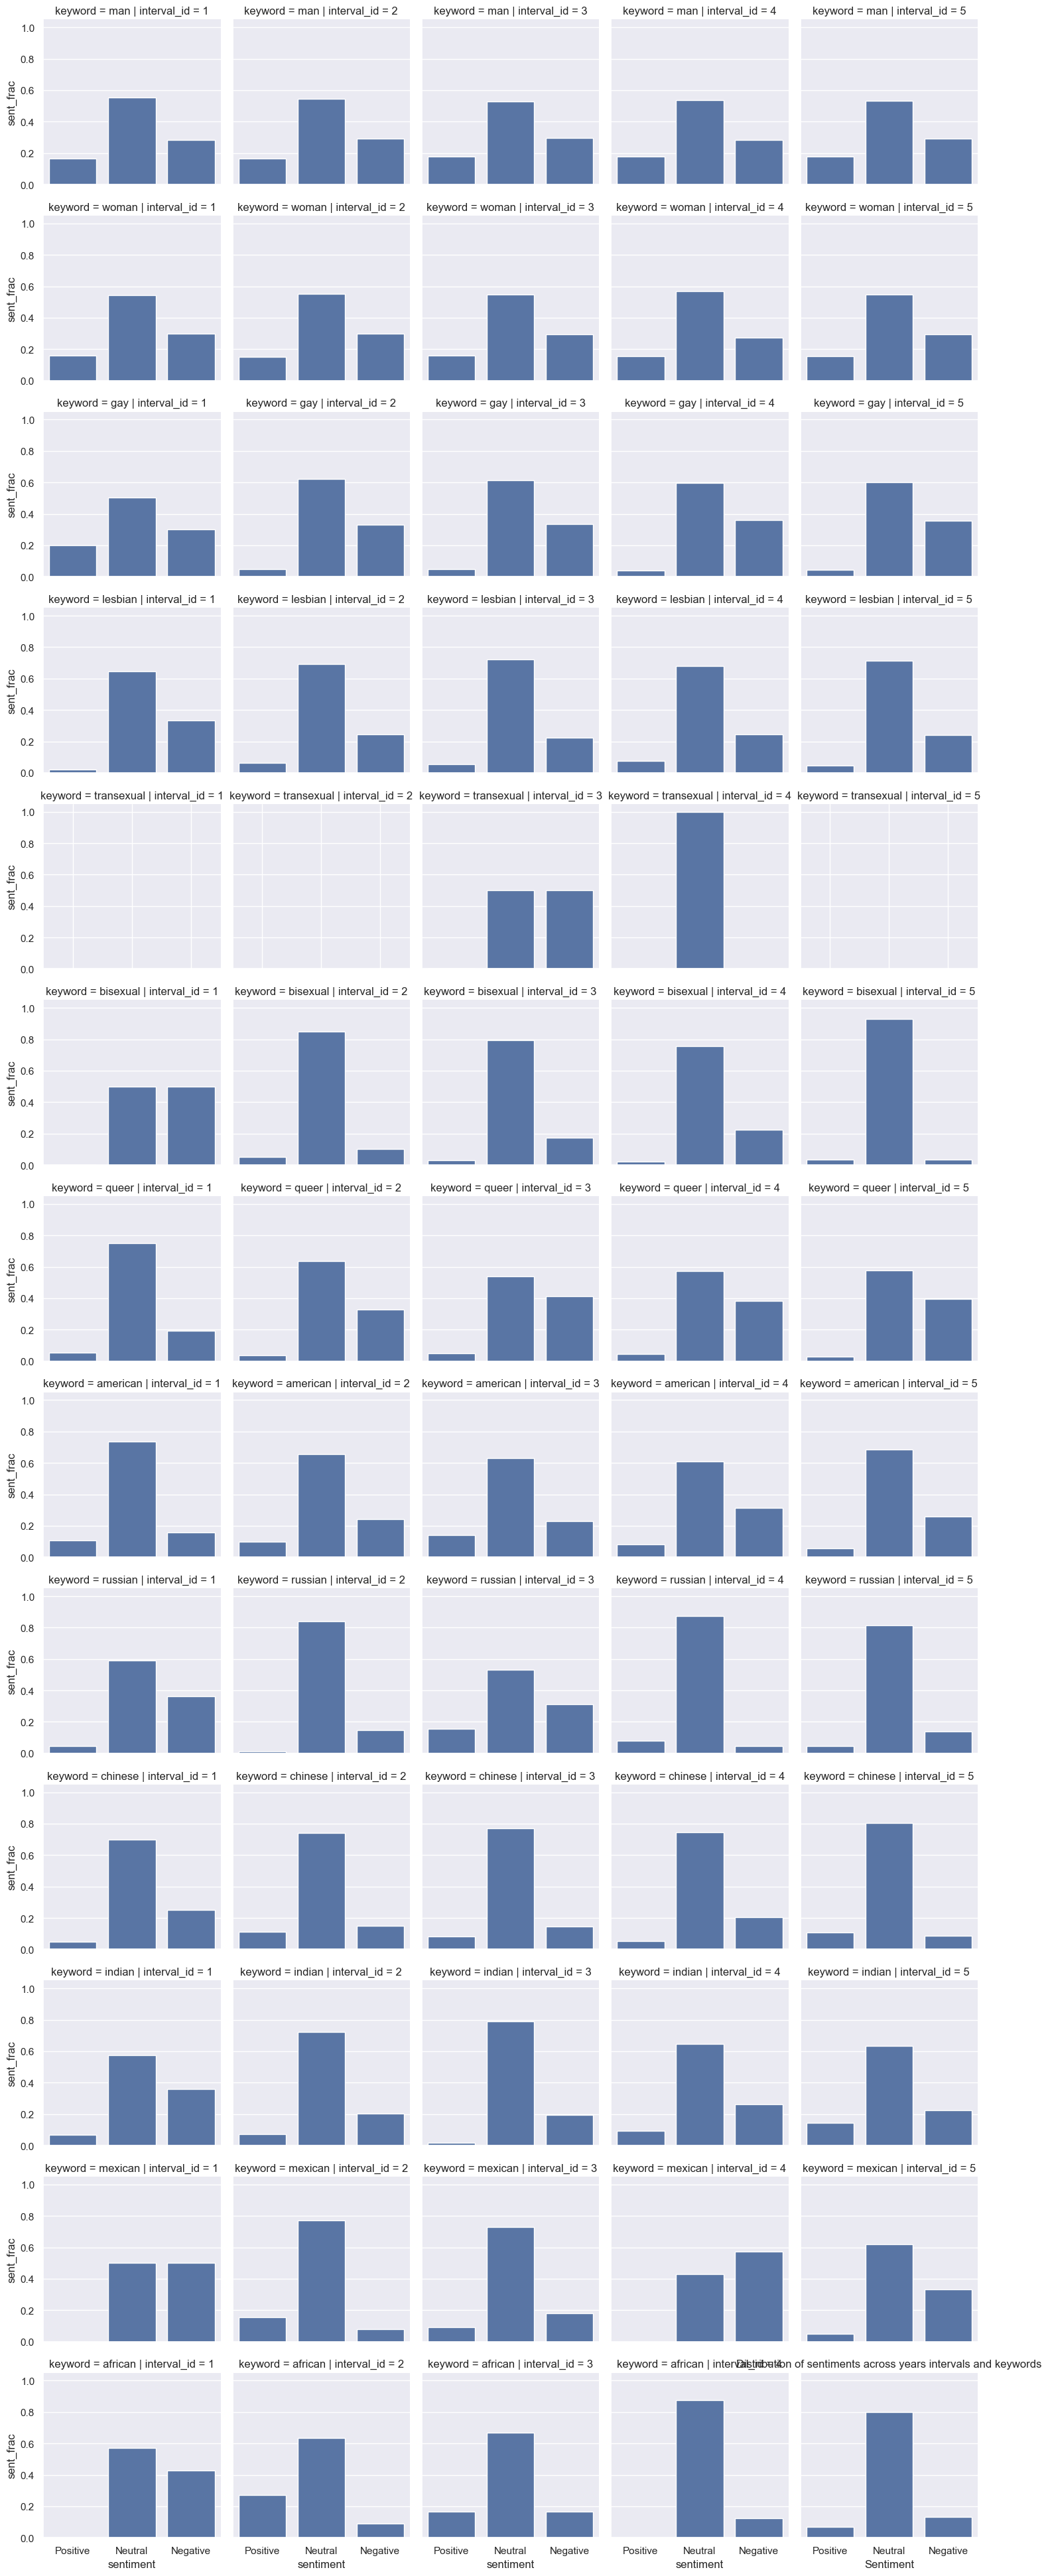

In [238]:
g = sns.FacetGrid(df_sent_stats, col='interval_id', row='keyword')
g.map(sns.barplot, 'sentiment', 'sent_frac')

plt.title('Distribution of sentiments across years intervals and keywords')
plt.xlabel('Sentiment')
plt.ylabel('Fraction')

#### Average sentiment scores

In [78]:
# Confidence interval with bootstraping
def bootstrap_CI(data, nbr_draws=10000, CI=95):
    gamma = (100-CI)/2
    means = np.zeros(nbr_draws)
    data = np.array(data)
    sample_size = len(data)

    for n in tqdm(range(nbr_draws), leave=False):
        indices = np.random.randint(0, sample_size, sample_size)
        bootstrap_resamples = data[indices] 
        means[n] = np.nanmean(bootstrap_resamples)

    return np.nanmean(data), np.nanpercentile(means, gamma), np.nanpercentile(means, 100-gamma)

For each keyword, we calculate 95% confidence intervals for mean sentiment score per year interval. We also split keywords with respect to their categories, i.e. diversity or ethnicity related keyword.

In [172]:
sentiments = []
for keyword in tqdm(KEYWORDS):
    df_sentences = sentences[keyword]
    
    for idx, group in df_sentences.groupby('interval_id'):
        sents = group['Label'].values
        mean_sent, CI_low, CI_high = bootstrap_CI(sents, nbr_draws=1000)
        keyword_stats = {
            'keyword': keyword,
            'sentiments' : sents,
            'mean_sent': mean_sent,
            'CI_low': CI_low,
            'CI_high': CI_high,
            'interval_id': idx
        }
        
        sentiments.append(keyword_stats)
df_sentiments = pd.DataFrame(sentiments)

# In Plotly, errors are given as relative positions to the data value
df_sentiments['e_plus'] = df_sentiments['CI_high']-df_sentiments['mean_sent']
df_sentiments['e_minus'] = df_sentiments['mean_sent']-df_sentiments['CI_low']

# Set the keyword category
df_sentiments['Type'] = None
df_sentiments.loc[df_sentiments['keyword'].isin(KEYWORDS_DIVERSITY), 'Type'] = 'Diversity'
df_sentiments.loc[df_sentiments['keyword'].isin(KEYWORDS_ETHNICITY), 'Type'] = 'Ethnicity'


# The same analysis for context windows
sentiments_context = []
for keyword in tqdm(KEYWORDS):
    df_contexts = contexts[keyword]
    
    for idx, group in df_contexts.groupby('interval_id'):
        sents = group['Label'].values
        mean_sent, CI_low, CI_high = bootstrap_CI(sents, nbr_draws=1000)
        keyword_stats = {
            'keyword': keyword,
            'sentiments' : sents,
            'mean_sent': mean_sent,
            'CI_low': CI_low,
            'CI_high': CI_high,
            'interval_id': idx
        }
        
        sentiments_context.append(keyword_stats)
        
df_sentiments_context = pd.DataFrame(sentiments_context)
df_sentiments_context['e_plus'] = df_sentiments_context['CI_high']-df_sentiments_context['mean_sent']
df_sentiments_context['e_minus'] = df_sentiments_context['mean_sent']-df_sentiments_context['CI_low']
df_sentiments_context['Type'] = None
df_sentiments_context.loc[df_sentiments_context['keyword'].isin(KEYWORDS_DIVERSITY), 'Type'] = 'Diversity'
df_sentiments_context.loc[df_sentiments_context['keyword'].isin(KEYWORDS_ETHNICITY), 'Type'] = 'Ethnicity'

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

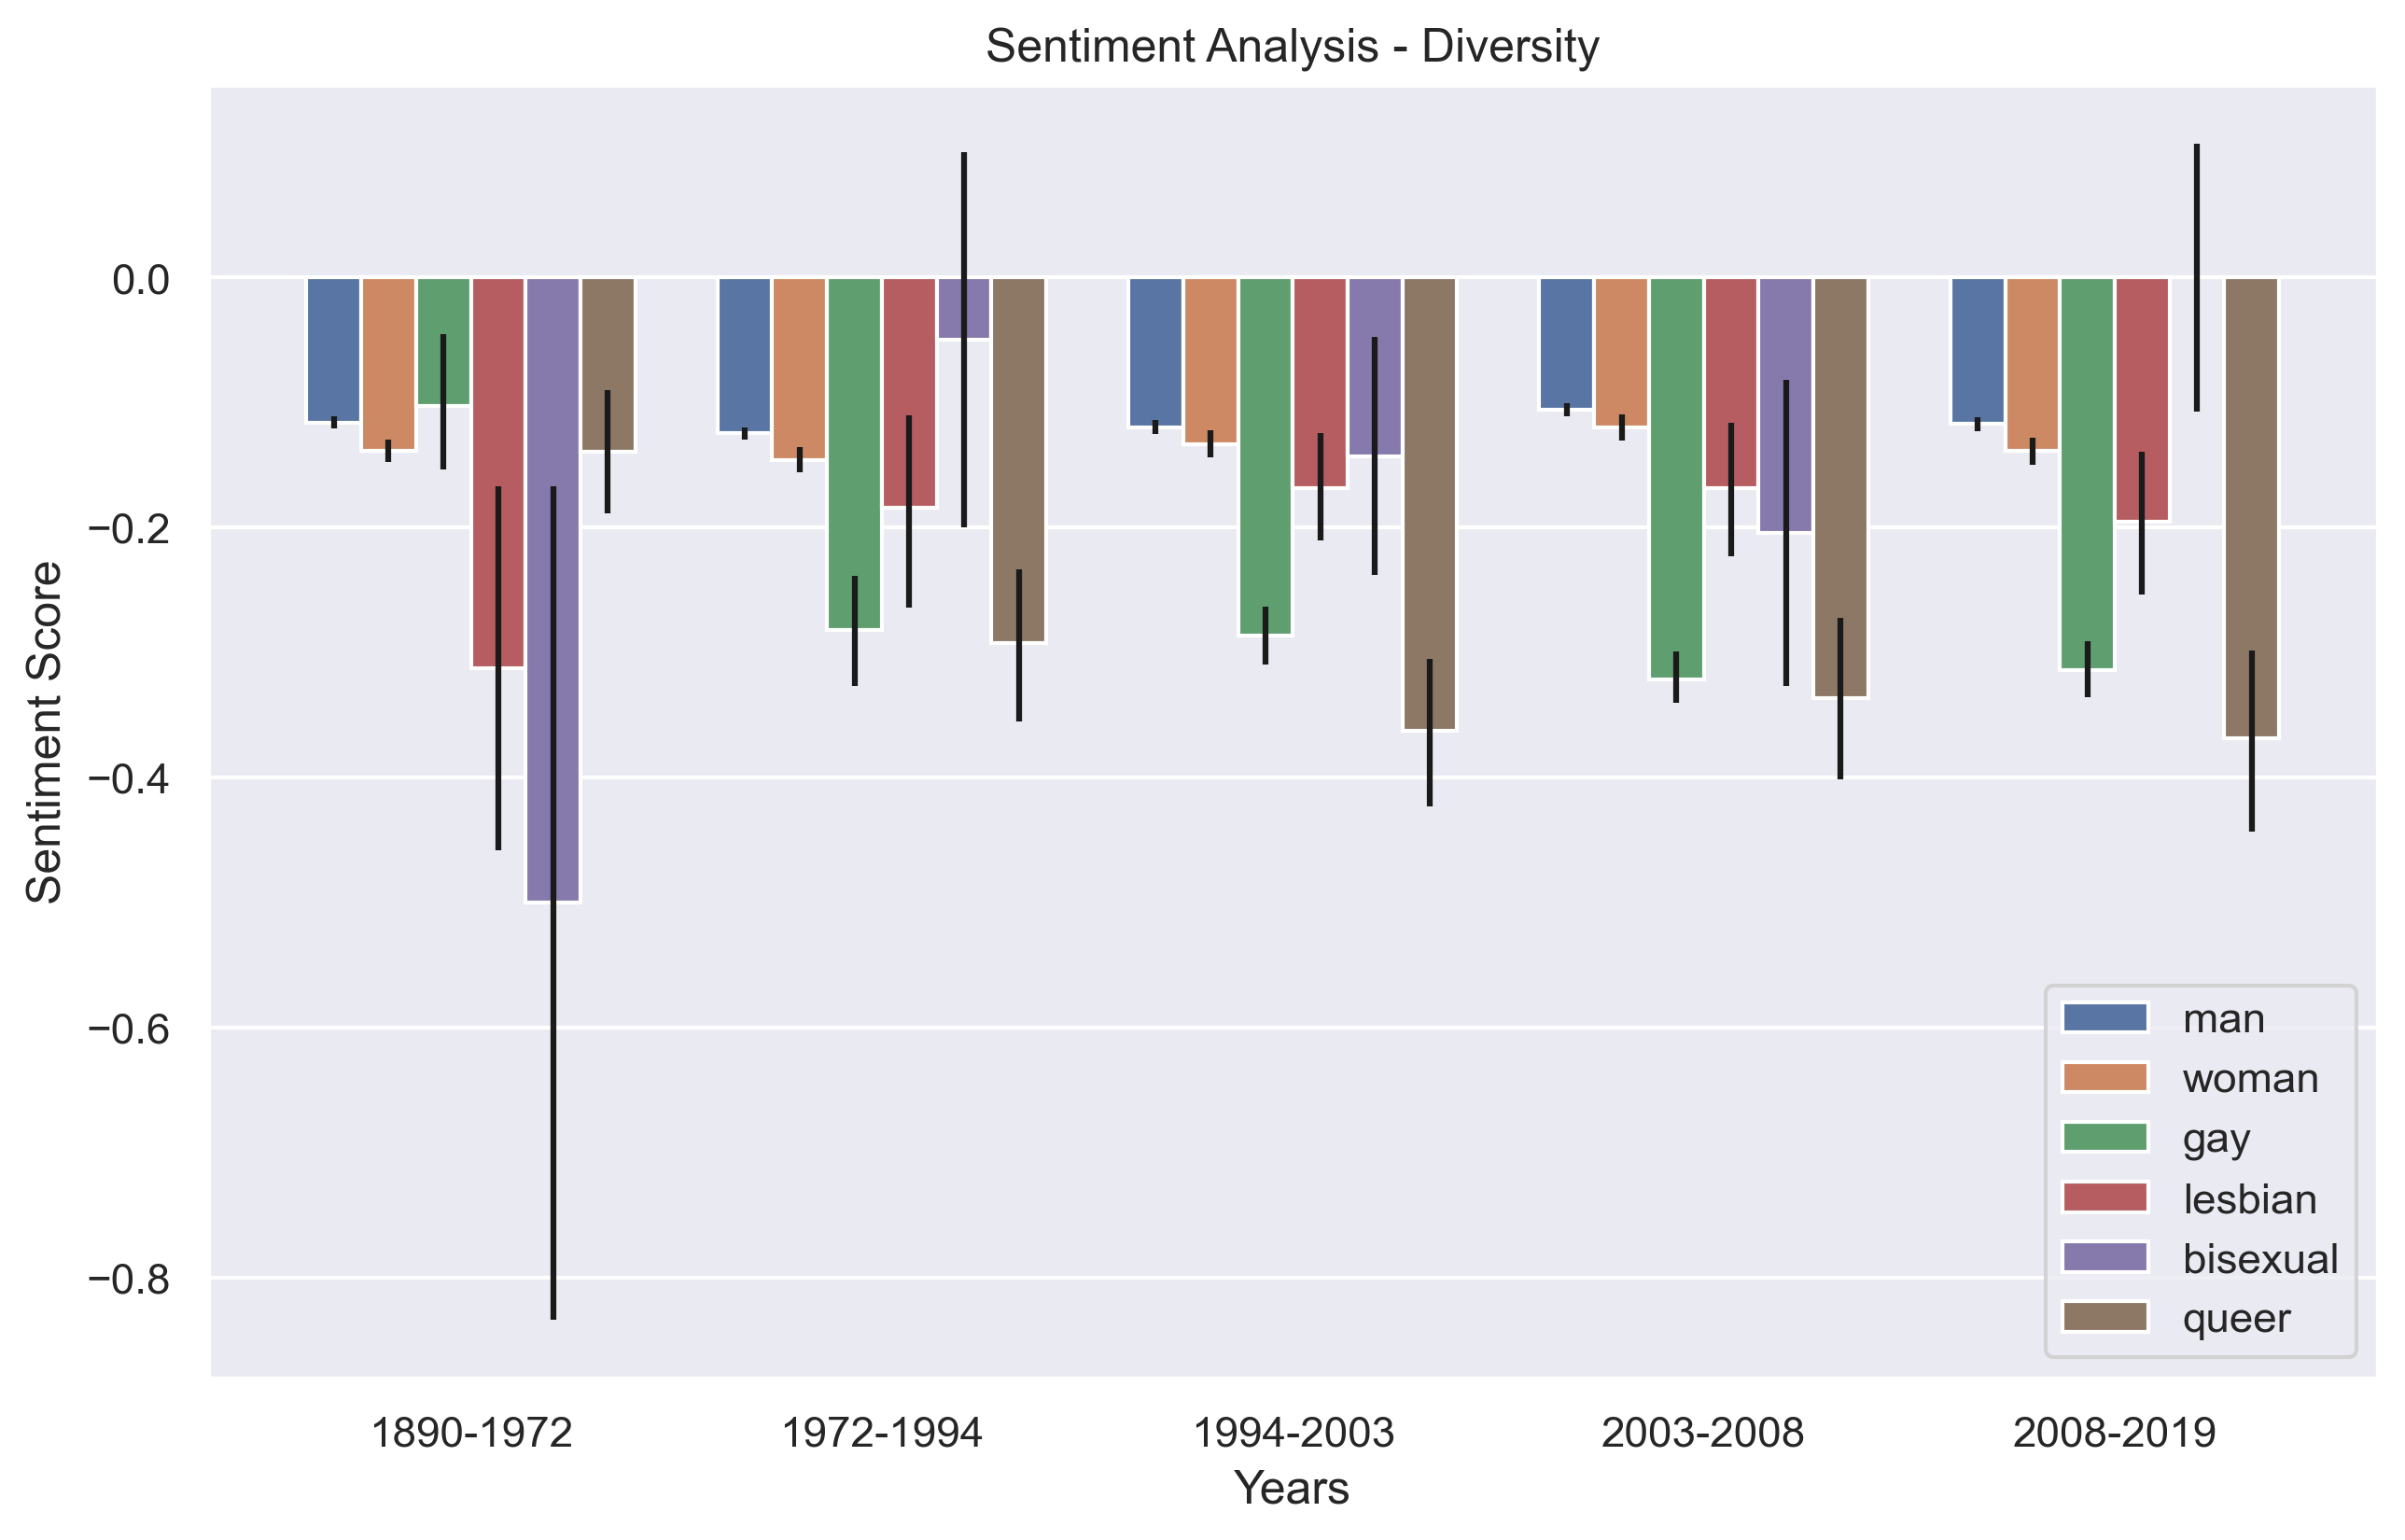

In [173]:
df = df_sentiments[df_sentiments['Type']=='Diversity']


fig, ax = plt.subplots(dpi=300, figsize=(10, 6))
ax = sns.barplot(df, x='interval_id', y='mean_sent', hue='keyword', ax=ax)

# Add 95% confidence interval
x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
errors = df['e_minus']
plt.errorbar(x=x_coords, y=y_coords, yerr=(df['e_minus'], df['e_plus']), fmt='none', c= 'k')

ax.set_title('Sentiment Analysis - Diversity')
ax.set_xticklabels(list(intervals.values()))
ax.set_xlabel('Years')
ax.set_ylabel('Sentiment Score')

ax.legend(loc='lower right')

1. The first thing to notice in the above plot is that for some of the entries the 95% confidence interval bars are quite large. The main reason behind this is having too few samples for those keywords in the respective year intervals. 
2. The other feature is that all of the average sentiments are negative, which is expected given the plots of distribution of sentiment above, showing `negative` sentiments are more than `negative` sentiments.
3. We observe that except for two cases `man` has the highest sentiment scores across years. It is followed by `women`, which has slightly worse sentiment than `man`. These two keywords have stable mean sentiment scores.
4. All of the remaining keywords carries more negative sentiments than `man` and `woman`, except for two cases. Furthermore, sentiments for `gay` and `queer` has attained lower values as the passes.

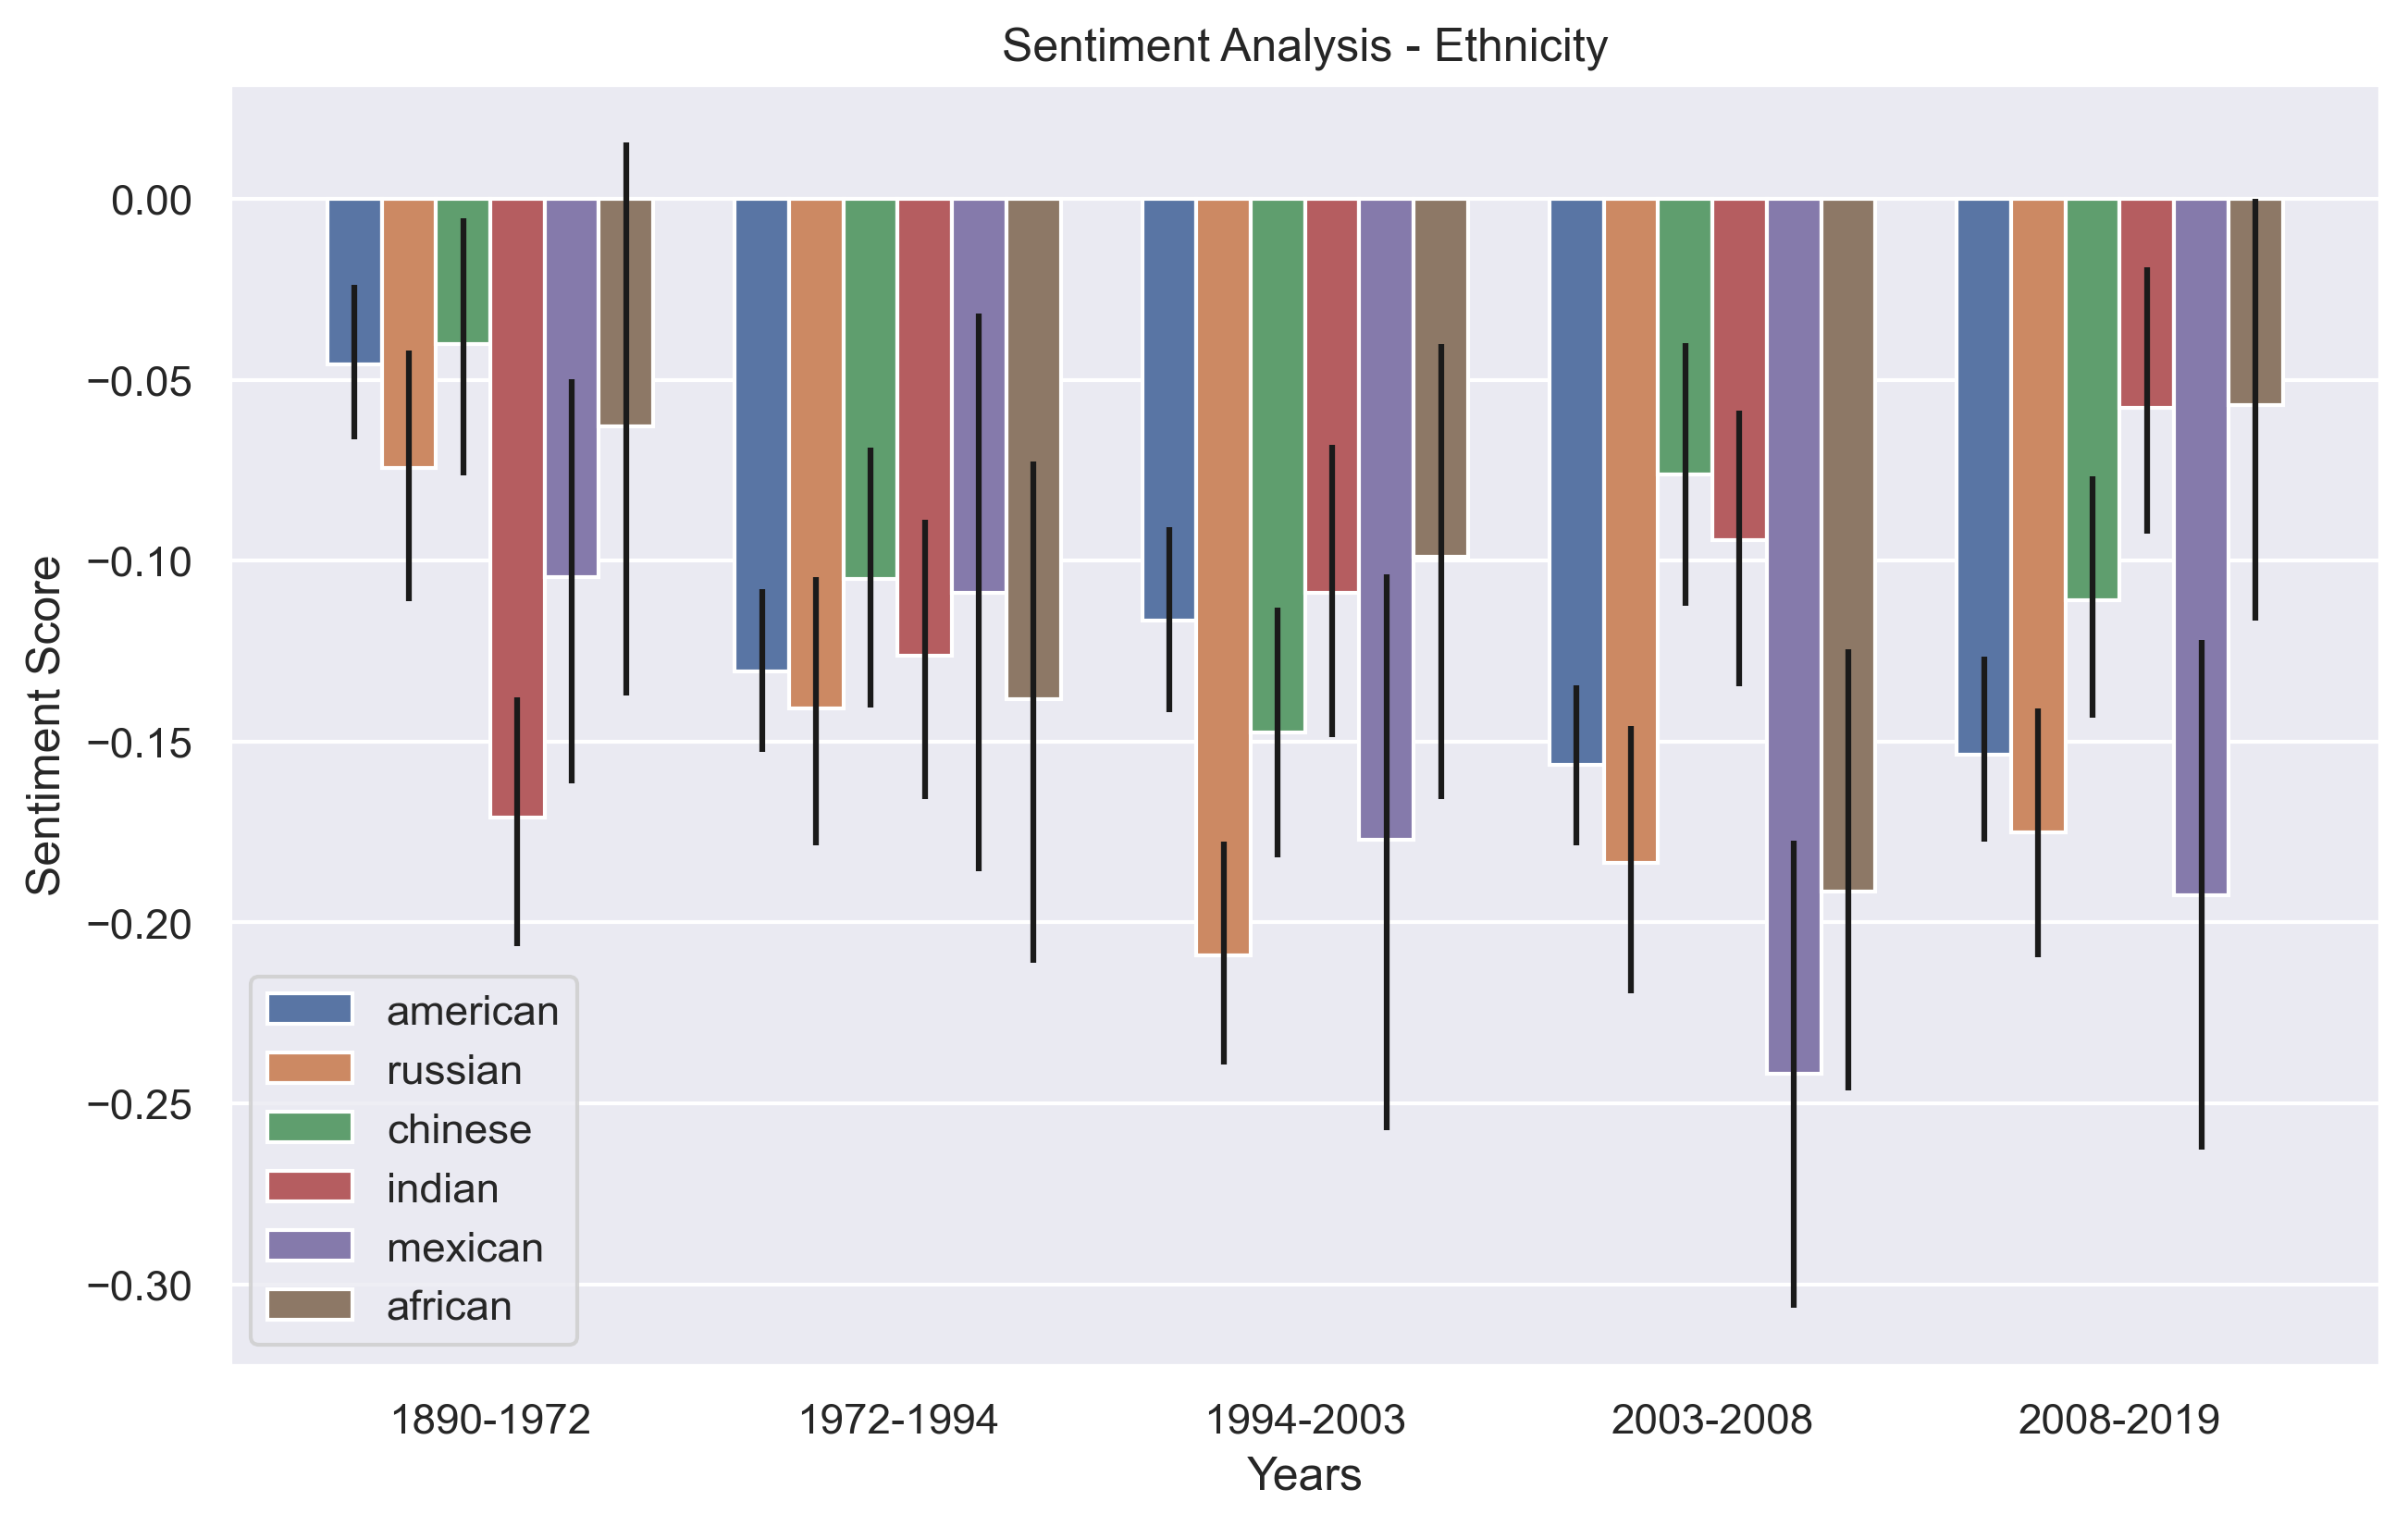

In [169]:
df = df_sentiments_context[df_sentiments_context['Type']=='Ethnicity']


fig, ax = plt.subplots(dpi=300, figsize=(10, 6))
ax = sns.barplot(df, x='interval_id', y='mean_sent', hue='keyword', ax=ax)

# Add 95% confidence interval
x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
errors = df['e_minus']
plt.errorbar(x=x_coords, y=y_coords, yerr=(df['e_minus'], df['e_plus']), fmt='none', c= 'k')

ax.set_title('Sentiment Analysis - Ethnicity')
ax.set_xticklabels(list(intervals.values()))
ax.set_xlabel('Years')
ax.set_ylabel('Sentiment Score')

ax.legend(loc='lower left')

#### Plotly plotting

Here are the plots used for our story website.

In [147]:
df = df_sentiments[df_sentiments['Type']=='Diversity']


fig = px.bar(
    df, 
    x='interval_id', 
    y='mean_sent', 
    color='keyword', 
    barmode='group',
    error_y='e_plus',
    error_y_minus='e_minus',
    labels={
         'interval_id': '<b>Years<b>',
         'mean_sent': '<b>Sentiment score<b>',
     },
    color_discrete_sequence=px.colors.qualitative.T10,
    template='ggplot2'
)

fig.update_layout(
    xaxis = dict(
            tickmode = 'array',
            tickvals = list(intervals.keys()),
            ticktext = list(intervals.values())
        ),

    title={
        'text': '<b>Sentiment Analysis - Diversity<b>',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.write_html(Path('../plots/sentiment_divesity.html'))

fig.show()

C:\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [94]:
df = df_sentiments_context[df_sentiments_context['Type']=='Ethnicity']
fig = px.bar(
    df, 
    x='interval_id', 
    y='mean_sent', 
    color='keyword', 
    barmode='group',
    labels={
         'interval_id': '<b>Years<b>',
         'mean_sent': '<b>Sentiment score<b>',
     },
    error_y='e_plus',
    error_y_minus='e_minus',
    color_discrete_sequence=px.colors.qualitative.T10,
    template='ggplot2'
    
)

fig.update_layout(
    xaxis = dict(
            tickmode = 'array',
            tickvals = list(intervals.keys()),
            ticktext = list(intervals.values())
        ),

    title={
        'text': '<b>Sentiment Analysis - Ethinicty<b>',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font':{
            'size':20,
        }
    },
    
)

fig.write_html(Path('../plots/sentiment_ethnicity.html'))


fig.show()

C:\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## Word Embeddings

In this section we are interested in how the context of the keywords of interest has changed over time. To analyze this, we train different `word2vec` models for each interval.

In [ ]:
WINDOW_SIZE = 5 # Size of the context window

In [ ]:
word2vec_models = {}

for group_id, group in tqdm(subtitles_with_dates.groupby('interval_id')):
    # For each interval, train a new model from scratch
    docs = [list(doc) for doc in group['Text'].tolist()]
                
    model = Word2Vec(sentences=docs, vector_size=100, window=WINDOW_SIZE, epochs=5, min_count=30, workers=8)
    word2vec_models[group_id] = model

In [ ]:
for k,v in word2vec_models.items():
    v.save(f'../models/subtitle_word2vec/interval_{k}_winsize_{WINDOW_SIZE}.model')

### Analyze the results

In [68]:
word2vec_models = {}
WINDOW_SIZE = 5 # Either 5 or 10 is available

for k in range(1, 6):
    word2vec_models[k] = Word2Vec.load(f"../models/subtitle_word2vec/interval_{k}_winsize_{WINDOW_SIZE}.model")

In [267]:
keyword = 'gay'

for k,v in word2vec_models.items():
    df = subtitles_with_dates[subtitles_with_dates['interval_id']==k]
    year_min, year_max = df['year'].min(), df['year'].max()
    
    print(f'Top words released to {keyword} in movies between {year_min}-{year_max}')
    if keyword not in v.wv: continue
    for item in v.wv.most_similar(keyword, topn=10):
        print('\t',item)
        
    print()

Top words released to gay in movies between 1890-1972
	 ('carefree', 0.7681794166564941)
	 ('cheerful', 0.7379952073097229)
	 ('brighten', 0.6614827513694763)
	 ('gloomy', 0.6449736952781677)
	 ('dreary', 0.6204192638397217)
	 ('enchanting', 0.6202699542045593)
	 ('lark', 0.6100409626960754)
	 ('romantic', 0.6048668622970581)
	 ('delightful', 0.5856819748878479)
	 ('charming', 0.5841920971870422)

Top words released to gay in movies between 1972-1994
	 ('lesbian', 0.6742017865180969)
	 ('homosexual', 0.6011388897895813)
	 ('fag', 0.5714848041534424)
	 ('queer', 0.5496288537979126)
	 ('fickle', 0.5420777201652527)
	 ('groupie', 0.5392196178436279)
	 ('heterosexual', 0.5369699597358704)
	 ('Gay', 0.5342585444450378)
	 ('dame', 0.5322725772857666)
	 ('loner', 0.5127857327461243)

Top words released to gay in movies between 1994-2003
	 ('lesbian', 0.758385419845581)
	 ('bisexual', 0.7411475777626038)
	 ('homosexual', 0.7285181879997253)
	 ('homo', 0.6543673872947693)
	 ('heterosexual', 0.6

In the example above shows the 10 similar word embeddings for `gay`. We observe that in the first interval, the keyword is overall closer to adjectives and nouns with positive semantics. As the time progresses, the meaning of the keyword become similar to other LGBT nouns and the defining adjective appears to carry more negative meanings.

In [271]:
keyword = 'man'

for k,v in word2vec_models.items():
    df = subtitles_with_dates[subtitles_with_dates['interval_id']==k]
    year_min, year_max = df['year'].min(), df['year'].max()
    
    print(f'Top words released to {keyword} in movies between {year_min}-{year_max}')
    if keyword not in v.wv: continue
    for item in v.wv.most_similar(keyword, topn=10):
        print('\t',item)
        
    print()

Top words released to man in movies between 1890-1972
	 ('woman', 0.7003790140151978)
	 ('people', 0.5175936222076416)
	 ('fellow', 0.491482138633728)
	 ('soldier', 0.4862159192562103)
	 ('whippersnapper', 0.4684760272502899)
	 ('strong', 0.45336031913757324)
	 ('brave', 0.4519982635974884)
	 ('person', 0.4392673969268799)
	 ('intelligent', 0.4370500445365906)
	 ('experienced', 0.4322097897529602)

Top words released to man in movies between 1972-1994
	 ('woman', 0.6777275800704956)
	 ('wise', 0.48585620522499084)
	 ('people', 0.4774063229560852)
	 ('nigger', 0.4679310619831085)
	 ('guy', 0.46718093752861023)
	 ('motherfucker', 0.46679702401161194)
	 ('macho', 0.4663205146789551)
	 ('dude', 0.45252370834350586)
	 ('geezer', 0.44914016127586365)
	 ('Man', 0.44270485639572144)

Top words released to man in movies between 1994-2003
	 ('woman', 0.6890328526496887)
	 ('macho', 0.5124172568321228)
	 ('grown', 0.5010052919387817)
	 ('bro', 0.49687328934669495)
	 ('nigger', 0.4816834330558777)

In [174]:
keyword = 'woman'

for k,v in word2vec_models.items():
    df = subtitles_with_dates[subtitles_with_dates['interval_id']==k]
    year_min, year_max = df['year'].min(), df['year'].max()
    
    print(f'Top words released to {keyword} in movies between {year_min}-{year_max}')
    if keyword not in v.wv: continue
    for item in v.wv.most_similar(keyword, topn=10):
        print('\t',item)
        
    print()

Top words released to woman in movies between 1890-1972
	 ('man', 0.700378954410553)
	 ('wife', 0.5636851787567139)
	 ('husband', 0.5421378016471863)
	 ('mature', 0.5064458847045898)
	 ('child', 0.49710771441459656)
	 ('attractive', 0.49701419472694397)
	 ('widow', 0.4942302703857422)
	 ('intuition', 0.493818074464798)
	 ('female', 0.49175140261650085)
	 ('alike', 0.4889388680458069)

Top words released to woman in movies between 1972-1994
	 ('man', 0.6777275800704956)
	 ('attractive', 0.5791079998016357)
	 ('grown', 0.5634806156158447)
	 ('husband', 0.5538429021835327)
	 ('sex', 0.5482300519943237)
	 ('wife', 0.5363627672195435)
	 ('lib', 0.5348953008651733)
	 ('lesbian', 0.5064201951026917)
	 ('female', 0.5059494376182556)
	 ('male', 0.49886825680732727)

Top words released to woman in movies between 1994-2003
	 ('man', 0.6890328526496887)
	 ('seduce', 0.6155197620391846)
	 ('attractive', 0.5964050889015198)
	 ('grown', 0.5886889696121216)
	 ('husband', 0.5413578748703003)
	 ('desira

The keyword `woman` is initially more similar to family-related words, such as `wife` and `widow`. This eventually changes and words carrying sexual meanings become closer to it, e.g. `attractive` and `prostitute`.

### Topic modelling

We are also interested in the possibility of discovering topics from subtitles. We adapted Latent Dirichlet Allocation (LDA) part from ADA textual analysis exercise to learn a topic model.

#### Train an LDA model

Unfortunately, none of the LGBT-related movies have subtitles in our dataset. To find movies that might be related to LGBT issues, we used Empath package to rate subtitles.

In [ ]:
lexicon = Empath()

lexicon.create_category('lgbt', ['rights', 'lesbian', 'gay', 'trans', 'transsexual', 'queer','asexual','heterosexual'], model='nytimes')

In [ ]:
docs = subtitles_tokinezed.copy()
docs['Full_text'] = docs['Text'].apply(lambda x: ' '.join(x))
docs['lexicon_score'] = docs.apply(lambda x: lexicon.analyze(x['Full_text'], categories = ['lgbt'])['lgbt'], axis=1)

docs = docs.loc[docs['lexicon_score']>0, 'Text'].tolist()
docs = [list(doc) for doc in docs]

In [ ]:
# Add bigrams with term-frequency>15 to docs.
bigram = Phrases(docs, min_count=15)

for doc in docs:
    for token in bigram[doc]:
        if '_' in token:
            # Token is a bigram, add to document.
            doc.append(token)

In [ ]:
dictionary = Dictionary(docs)

max_freq = 0.5 # Remove rare tokens.
min_wordcount = 5 # Remove common tokens.
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

corpus = [dictionary.doc2bow(doc) for doc in docs] # Bag-of-Words representations of documents

In [ ]:
# Latent Dirichlet Analysis
params = {'passes': 10, 'random_state': 0}
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=8,
                passes=params['passes'], random_state=params['random_state'])

In [ ]:
model.save(f'../models/lda.model')

#### Visualize

In [215]:
model = LdaMulticore.load(f'../models/lda.model')


# model.show_topics(num_words=5)

In [217]:
model.show_topic(2, 10)

[('Miss', 0.0025798916),
 ('husband', 0.0021342637),
 ('Father', 0.0019514322),
 ('evening', 0.0019476896),
 ('doctor', 0.0017576799),
 ('daughter', 0.001752187),
 ('gentleman', 0.0017255621),
 ('Lord', 0.0016975494),
 ('darling', 0.001670277),
 ('sister', 0.001510337)]

In [ ]:
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

## WordClouds

In this part, we visualize keywords in the form of word clouds with the most frequent terms they appear with. We also run an NLP pipeline to detect preceding adjectives for those keywords.

#### Extract adjectives

In [29]:
# NLP pipeline for extracting adjective/noun pairs
spacy.require_cpu()
nlp = spacy.load('en_core_web_lg')

adjectives = {}
for keyword in tqdm(KEYWORDS):
    # Pattern matching to find preceeding adjectives of a given keyword
    matcher = Matcher(nlp.vocab)
    patterns = [
        [{'POS':'ADJ'}, {'LOWER':keyword}],
        ]
    matcher.add(keyword, patterns)
    
    docs = sentences[keyword]['Text']
    
    # Creating child processes takes time on Windows, may not worth it if the size is small
    if len(docs)>1e5:
        n_process = 8
    else:
        n_process = 1
        
    adj_keyword = []
    for doc in tqdm(nlp.pipe(docs, n_process=n_process, batch_size=100), total=len(docs), leave=False):
        matches = matcher(doc)

        for match_id, start, end in matches:
            string_id = nlp.vocab.strings[match_id]  # Get string representation
            adj = doc[start]  # The matched adjective
            adj_keyword.append(adj.lemma_)
            
    adjectives[keyword] = Counter(adj_keyword)
    

with open(data_path.joinpath('processed/adjectives.json'), 'w', encoding='utf-8') as file:
        json.dump(adjectives, file)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/320314 [00:00<?, ?it/s]

  0%|          | 0/80147 [00:00<?, ?it/s]

  0%|          | 0/8390 [00:00<?, ?it/s]

  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1518 [00:00<?, ?it/s]

  0%|          | 0/650 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

#### Plotting

In [183]:
stopwords = wordcloud_stopwords.union({'Don', 'don'})

In [177]:
with open(data_path.joinpath('processed/adjectives.json'), 'r', encoding='utf-8') as file:
        adjectives = json.load(file)

In [260]:
keyword = 'gay'

term_counts = adjectives[keyword]

wc = WordCloud(max_font_size=200, 
               stopwords=stopwords,
               max_words = 30,
               collocation_threshold=5,
               background_color = 'white',
               scale = 20
              ).generate_from_frequencies(term_counts)

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: Deprecat

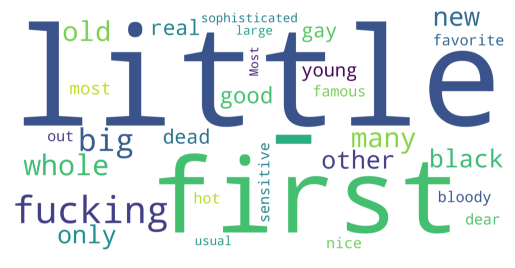

In [261]:
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [270]:
plot_path = Path('../plots/')

for keyword in tqdm(KEYWORDS):

    term_counts = adjectives[keyword]

    wc = WordCloud(max_font_size=200, 
                   stopwords=stopwords,
                   max_words = 40,
                   collocation_threshold=5,
                   background_color = 'white',
                   scale = 20
                  ).generate_from_frequencies(term_counts)
    
    wc.to_file(plot_path.joinpath(keyword + '.png'))

  0%|          | 0/13 [00:00<?, ?it/s]

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: Deprecat

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: Deprecat

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: Deprecat

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:520: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: Deprecatio

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: Deprecat

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: Deprecat

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: Deprecat

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: Deprecat

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: Deprecat

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:520: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: Deprecatio

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: Deprecat

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: Deprecat

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: Deprecat

Instead of just plotting a word cloud for adjectives, we can also plot words from all grammatical categories.

In [249]:
keyword = 'man'


terms = contexts[keyword]['Context'].tolist()
terms = list(chain(*terms)) # Concatenate lists
 

term_counts = Counter(terms)

for term in stopwords: del term_counts[term]

wc = WordCloud(max_font_size=200, 
               stopwords=stopwords,
               max_words = 30,
               collocation_threshold=5,
               background_color = 'white',
               scale = 20
              ).generate_from_frequencies(term_counts)

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: Deprecat

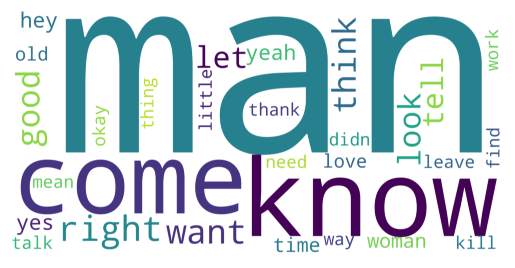

In [250]:
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()